In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from viz_functions import plot_steps
from util_functions import load_simulations_from_csv

# Model

In [2]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')

In [3]:
ground_air_runs_sim_folder = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/Simulations/'
ground_runs_sim_folder = './Test_Results/Test_Ground_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231127_185934/Simulations/'

# Loading simulations

In [4]:
ground_air_sims = [load_simulations_from_csv(ground_air_runs_sim_folder + f'run-{i}-sims.csv', model) for i in range(20)]
ground_sims = [load_simulations_from_csv(ground_runs_sim_folder + f'run-{i}-sims.csv', model) for i in range(20)]

# Pot paths

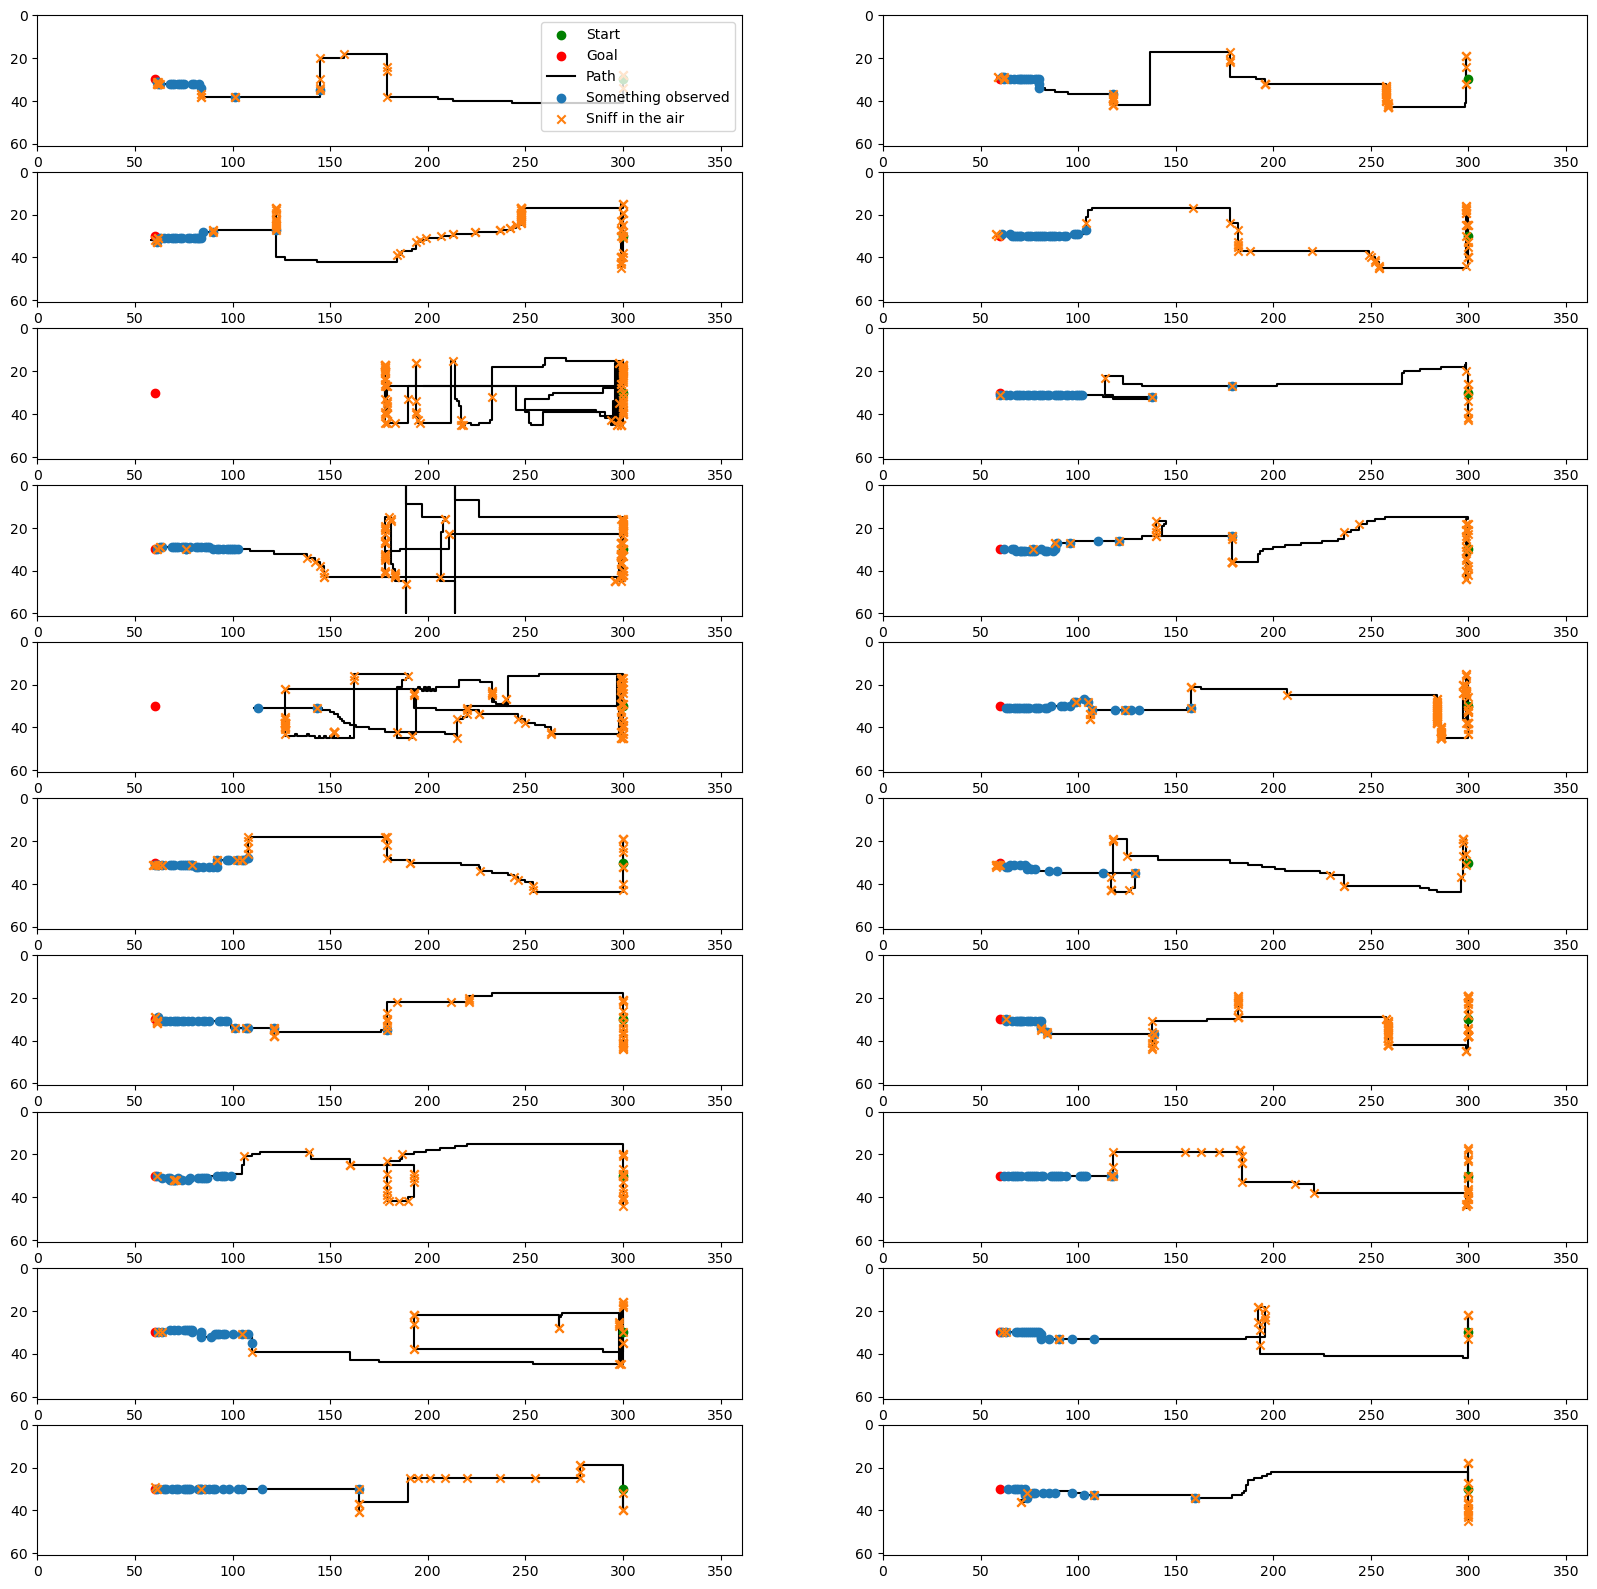

In [5]:
# Ground air
fig, axes = plt.subplots(10,2, figsize=(20,20))
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_steps(ground_air_sims[i][0], ax=ax)
    if i != 0:
        ax.legend().set_visible(False)

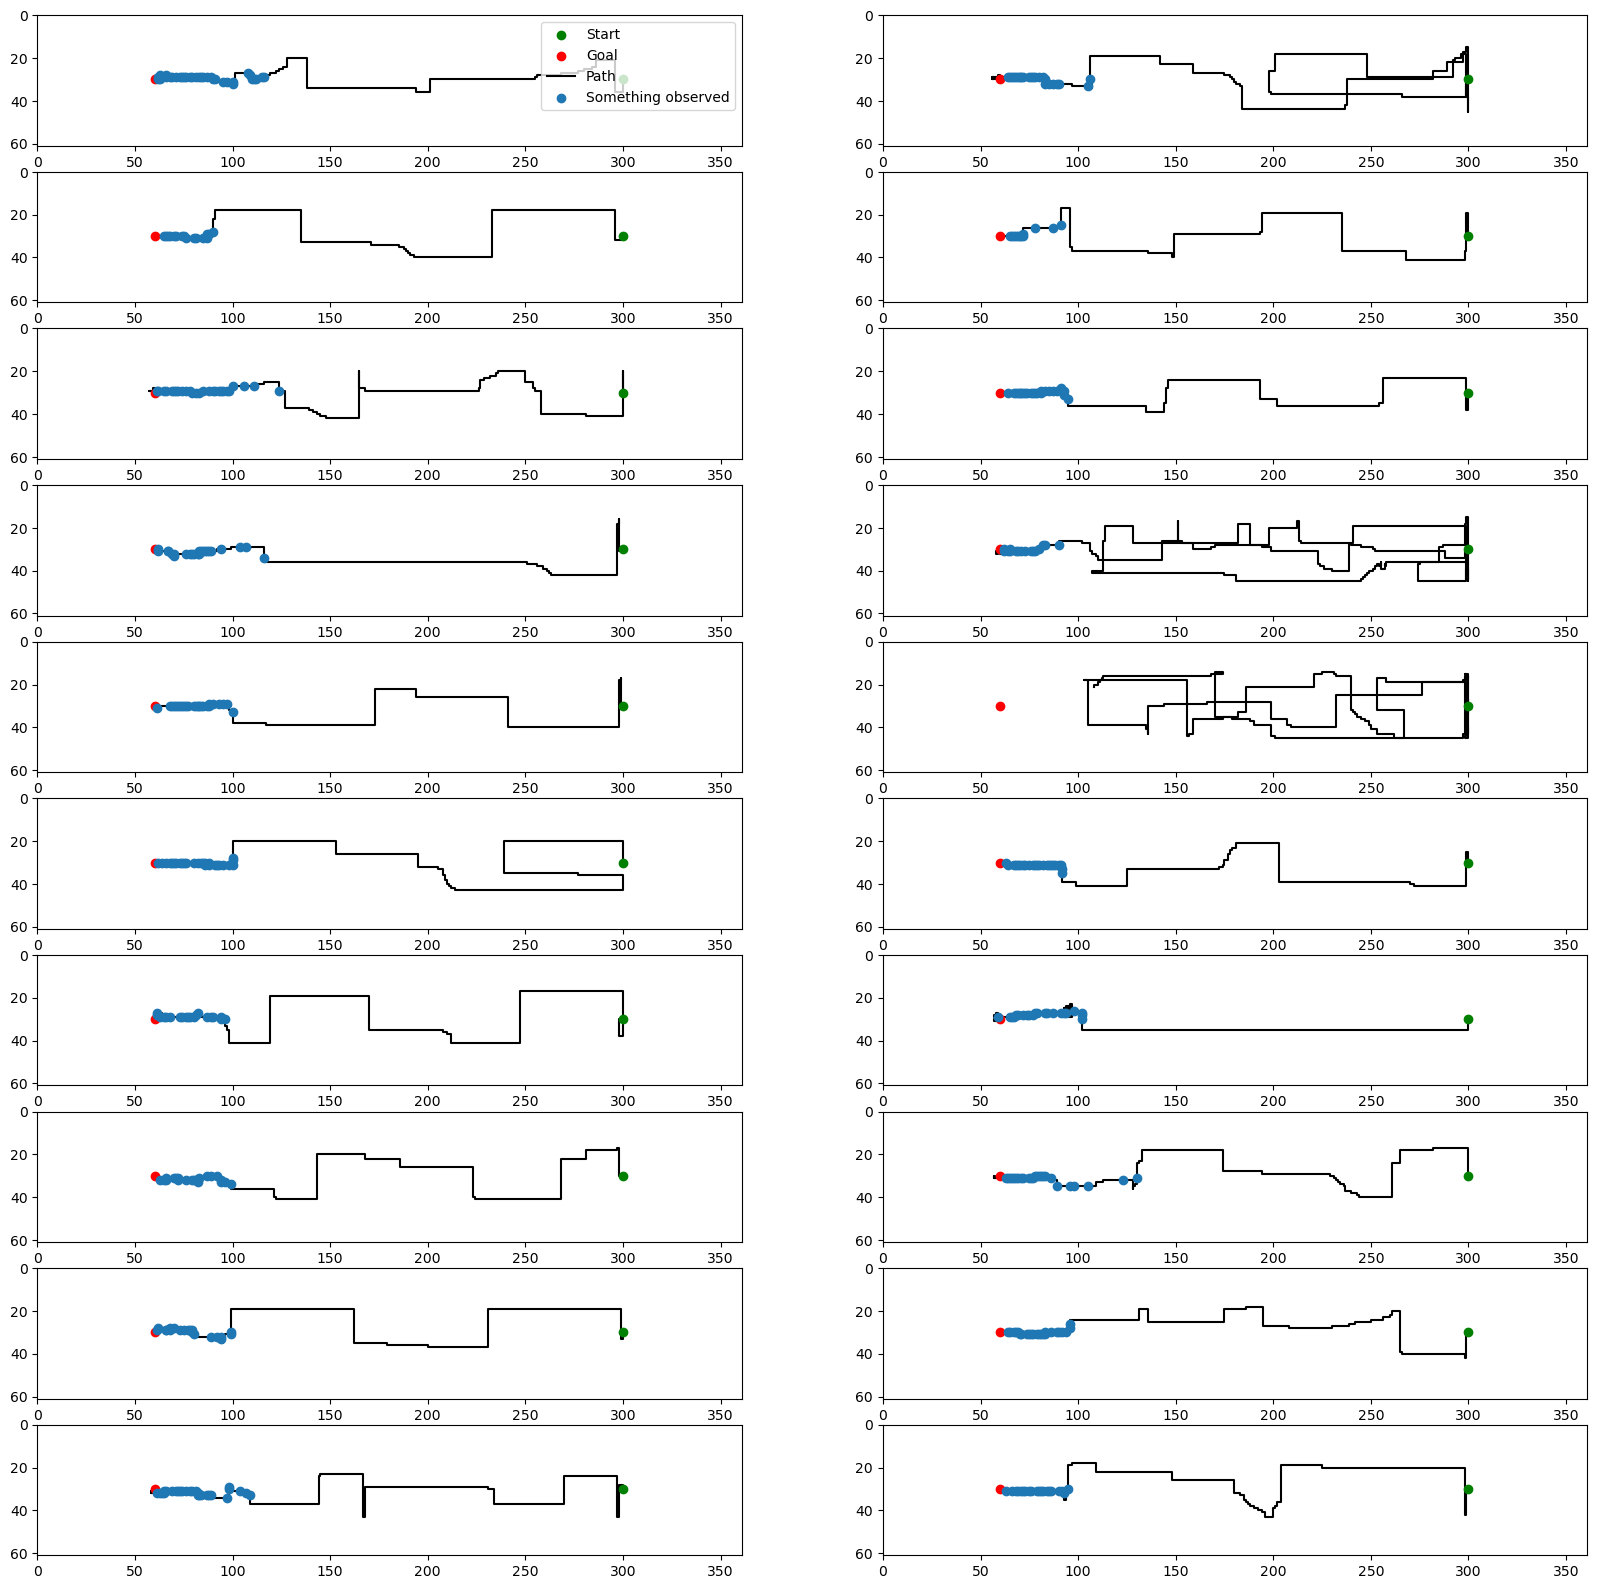

In [6]:
# Ground air
fig, axes = plt.subplots(10,2, figsize=(20,20))
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_steps(ground_sims[i][0], ax=ax)
    if i != 0:
        ax.legend().set_visible(False)

# Plot a

In [7]:
close_points = np.where(model.observation_table[:,5,1] > 0)[0]

In [8]:
def compute_close_far_rates(sim_set):
    close_rates = []
    far_rates = []
    for sim in sim_set:
        close_sniff_air = 0
        close_steps = 0

        far_sniff_air = 0
        far_steps = 0
        for s,a in zip(sim.states[1:], sim.actions):
            if s in close_points:
                close_steps += 1
                if a == 5:
                    close_sniff_air +=1
            else:
                far_steps += 1
                if a == 5:
                    far_sniff_air += 1

        close_rates.append((close_sniff_air / close_steps) if close_steps > 0 else 0)
        far_rates.append(far_sniff_air / far_steps)
    return close_rates, far_rates

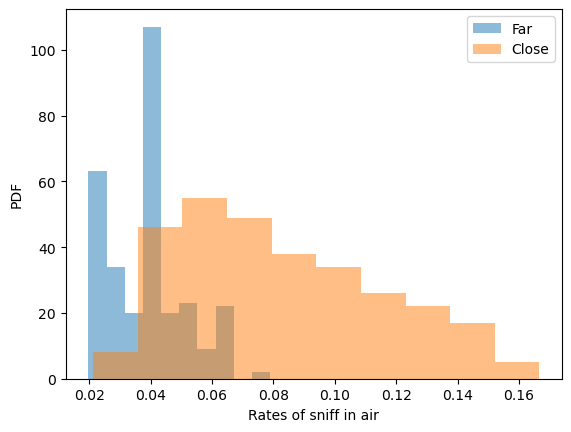

In [25]:
def plot_a(sim_list, ax):
    ax.set_ylabel('PDF')
    ax.set_xlabel('Rates of sniff in air')

    close_rates, far_rates = compute_close_far_rates(sim_list)

    ax.hist(far_rates, alpha=0.5, label='Far')
    ax.hist(close_rates, alpha=0.5, label='Close')
    ax.legend()

fig, ax1 = plt.subplots()
plot_a(ground_air_sims[0], ax1)
plt.show()

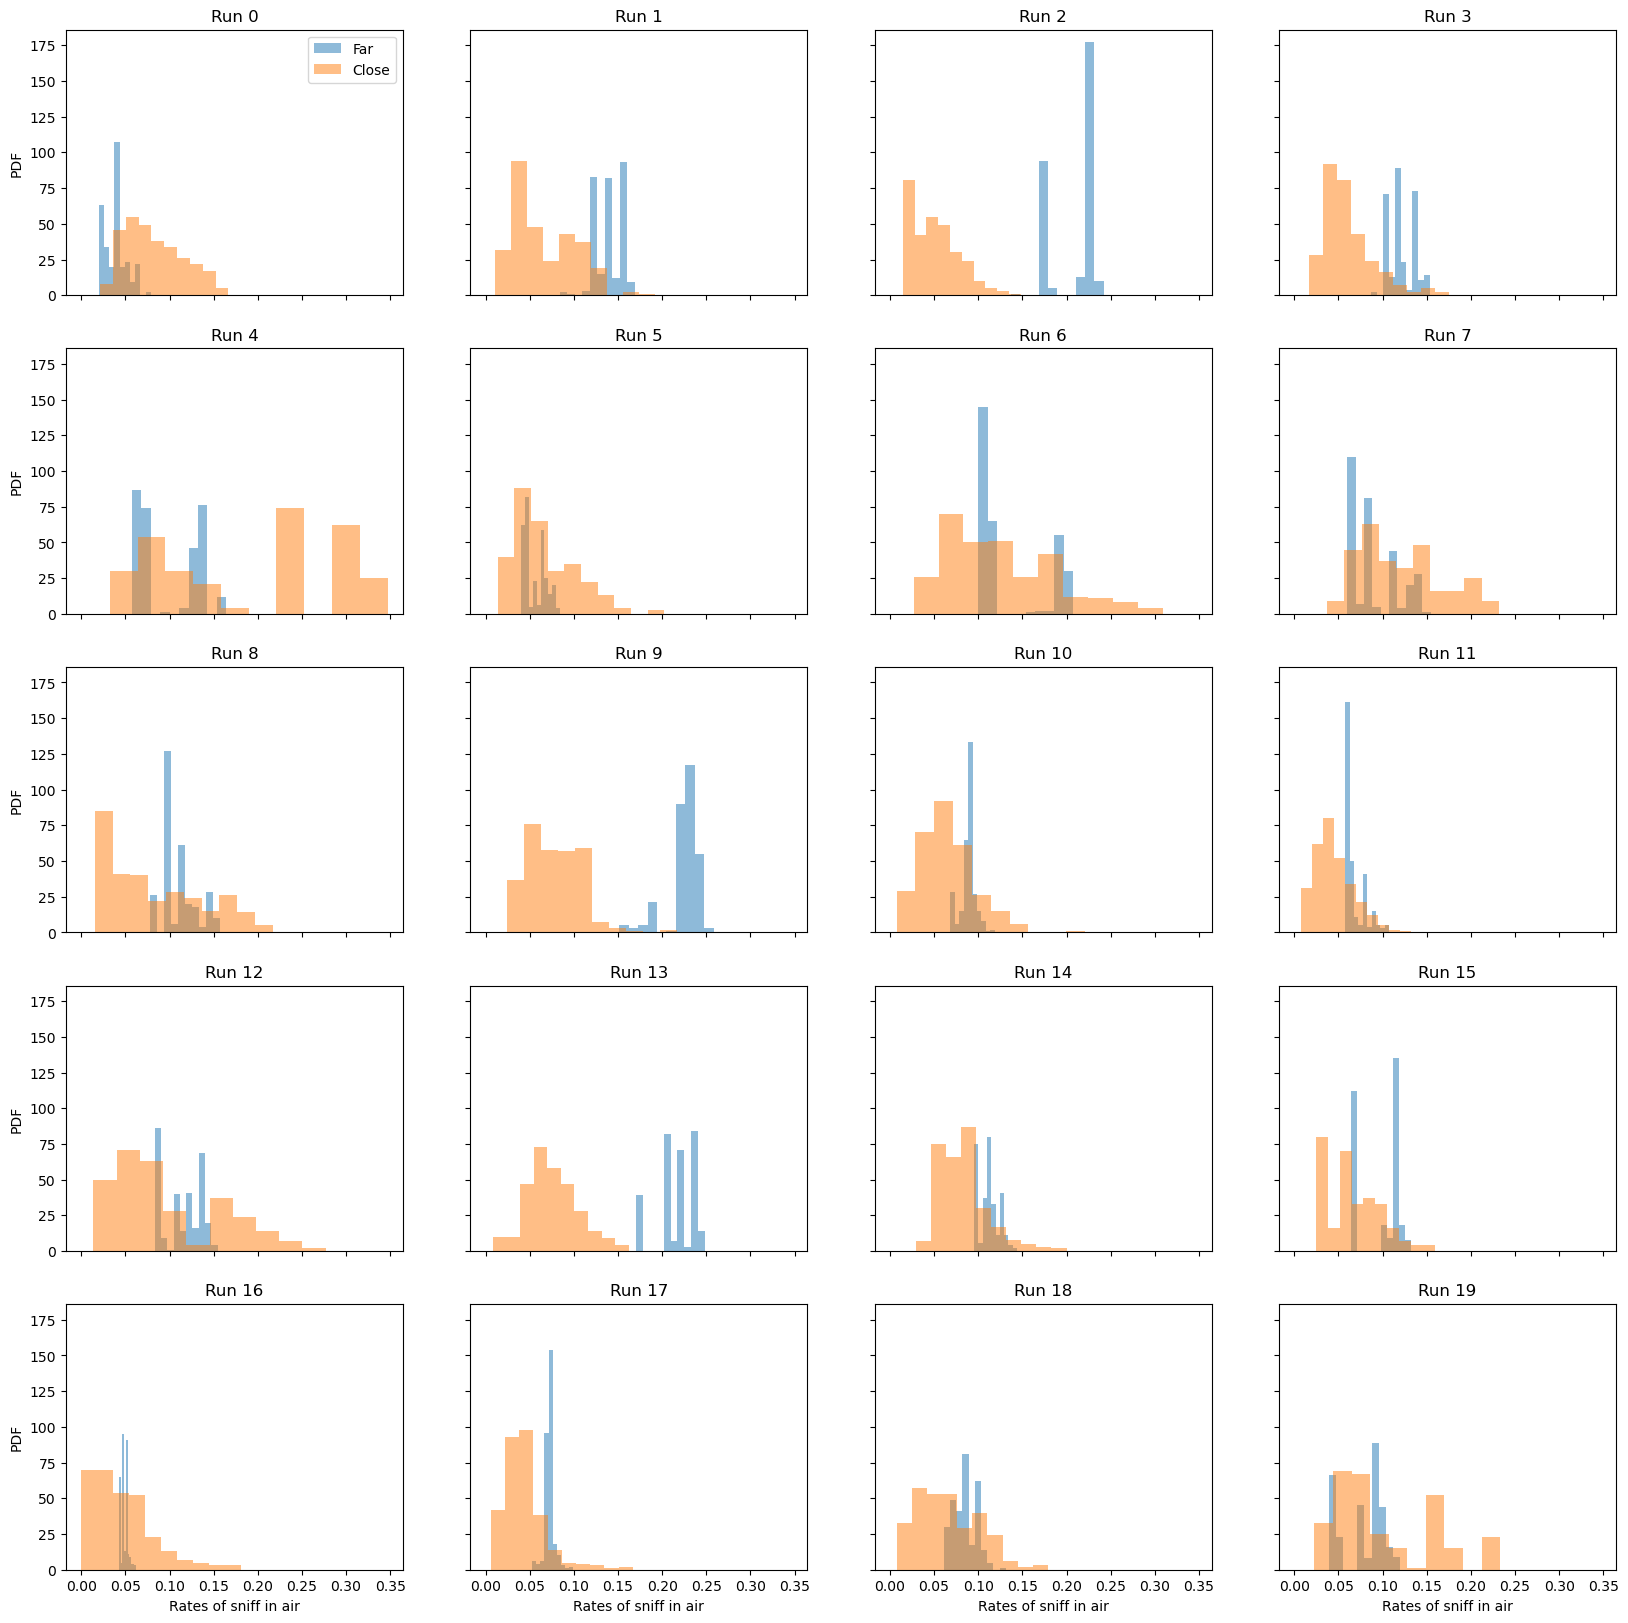

In [56]:
# Ground air
fig, axes = plt.subplots(5,4, figsize=(20,20), sharex=True, sharey=True)
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_a(ground_air_sims[i], ax=ax)
    ax.set_title(f'Run {i}')
    if i % 4 != 0:
        ax.set_ylabel(None)
    if i not in [16,17,18,19]:
        ax.set_xlabel(None)
    if i != 0:
        ax.legend().set_visible(False)

# Plot b

In [11]:
def compute_extra_steps(sim_list):
    extra_steps_list = []
    source_point = np.array(np.unravel_index(model.end_states[0], model.state_grid.shape))
    for sim in sim_list:
        start_point = np.array(np.unravel_index(sim.states[0], model.state_grid.shape))
        dist = np.sum(np.abs(source_point - start_point))
        extra_steps_list.append(len(sim) - dist)

    return extra_steps_list

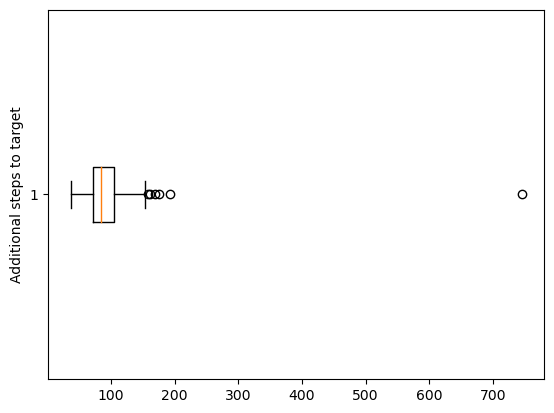

In [12]:
def plot_b(sim_list, ax):
    ax.set_ylabel('Additional steps to target')
    extra_steps = compute_extra_steps(sim_list)
    ax.boxplot(extra_steps, vert=False)

fig, ax1 = plt.subplots()
plot_b(ground_air_sims[0], ax1)
plt.show()

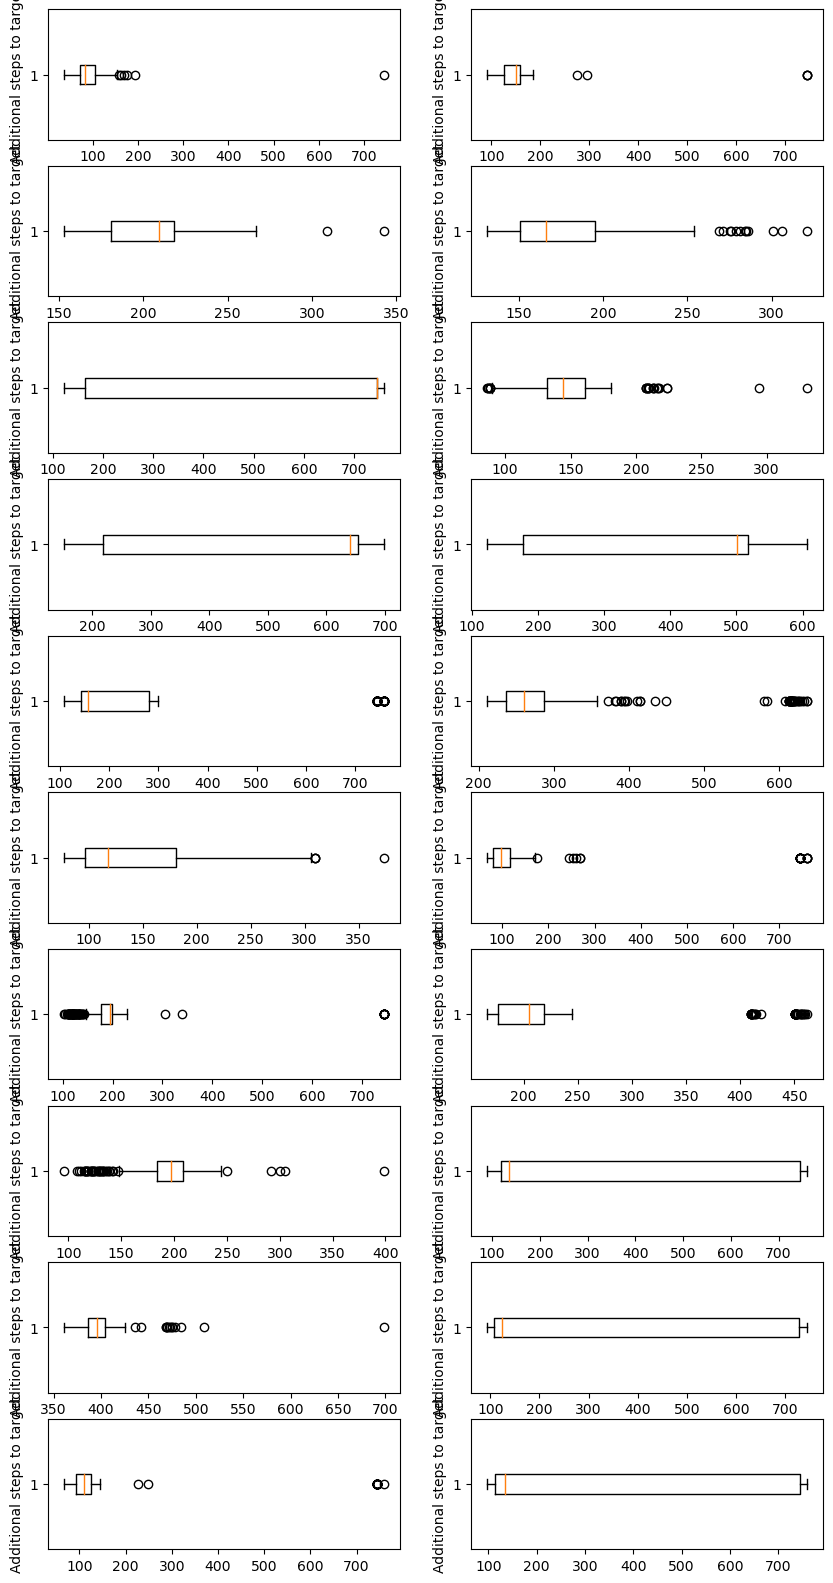

In [13]:
# Ground air
fig, axes = plt.subplots(10,2, figsize=(10,20))
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_b(ground_air_sims[i], ax=ax)

# Plot c

In [14]:
def compute_cast_surge_rates(sim_set):
    surge_rates = []
    cast_rates = []

    for sim in sim_set:

        # Cast action: 0 or 2
        is_action = np.where((np.array(sim.actions) == 0) | (np.array(sim.actions) == 2) | (np.array(sim.actions) == 5), 1, 0)
        is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
        cast_sequence = np.zeros(len(sim), dtype=bool)

        for i, el in enumerate(is_action_seq):
            if el == 3:
                cast_sequence[i:i+3] = True

        cast_count = np.sum(cast_sequence[:])
        cast_sniff = np.sum(cast_sequence[:] & (np.array(sim.actions) == 5))
        cast_rates.append(cast_sniff / cast_count)

        # Surge action: 3
        is_action = np.where((np.array(sim.actions) == 3) | (np.array(sim.actions) == 5), 1, 0)
        is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
        surge_sequence = np.zeros(len(sim), dtype=bool)

        for i, el in enumerate(is_action_seq):
            if el == 3:
                surge_sequence[i:i+3] = True

        surge_count = np.sum(surge_sequence[:])
        surge_sniff = np.sum(surge_sequence[:] & (np.array(sim.actions) == 5))
        surge_rates.append(surge_sniff / surge_count)

    return surge_rates, cast_rates

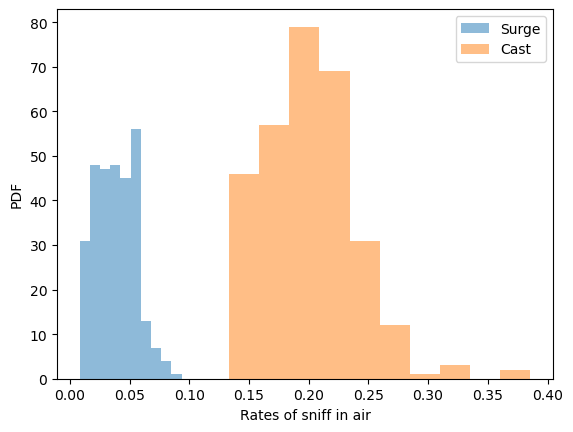

In [15]:
def plot_c(sim_list, ax):
    ax.set_ylabel('PDF')
    ax.set_xlabel('Rates of sniff in air')

    surge_rates, cast_rates = compute_cast_surge_rates(sim_list)

    ax.hist(surge_rates, alpha=0.5, label='Surge')
    ax.hist(cast_rates, alpha=0.5, label='Cast')
    ax.legend()

fig, ax1 = plt.subplots()
plot_c(ground_air_sims[0], ax1)
plt.show()

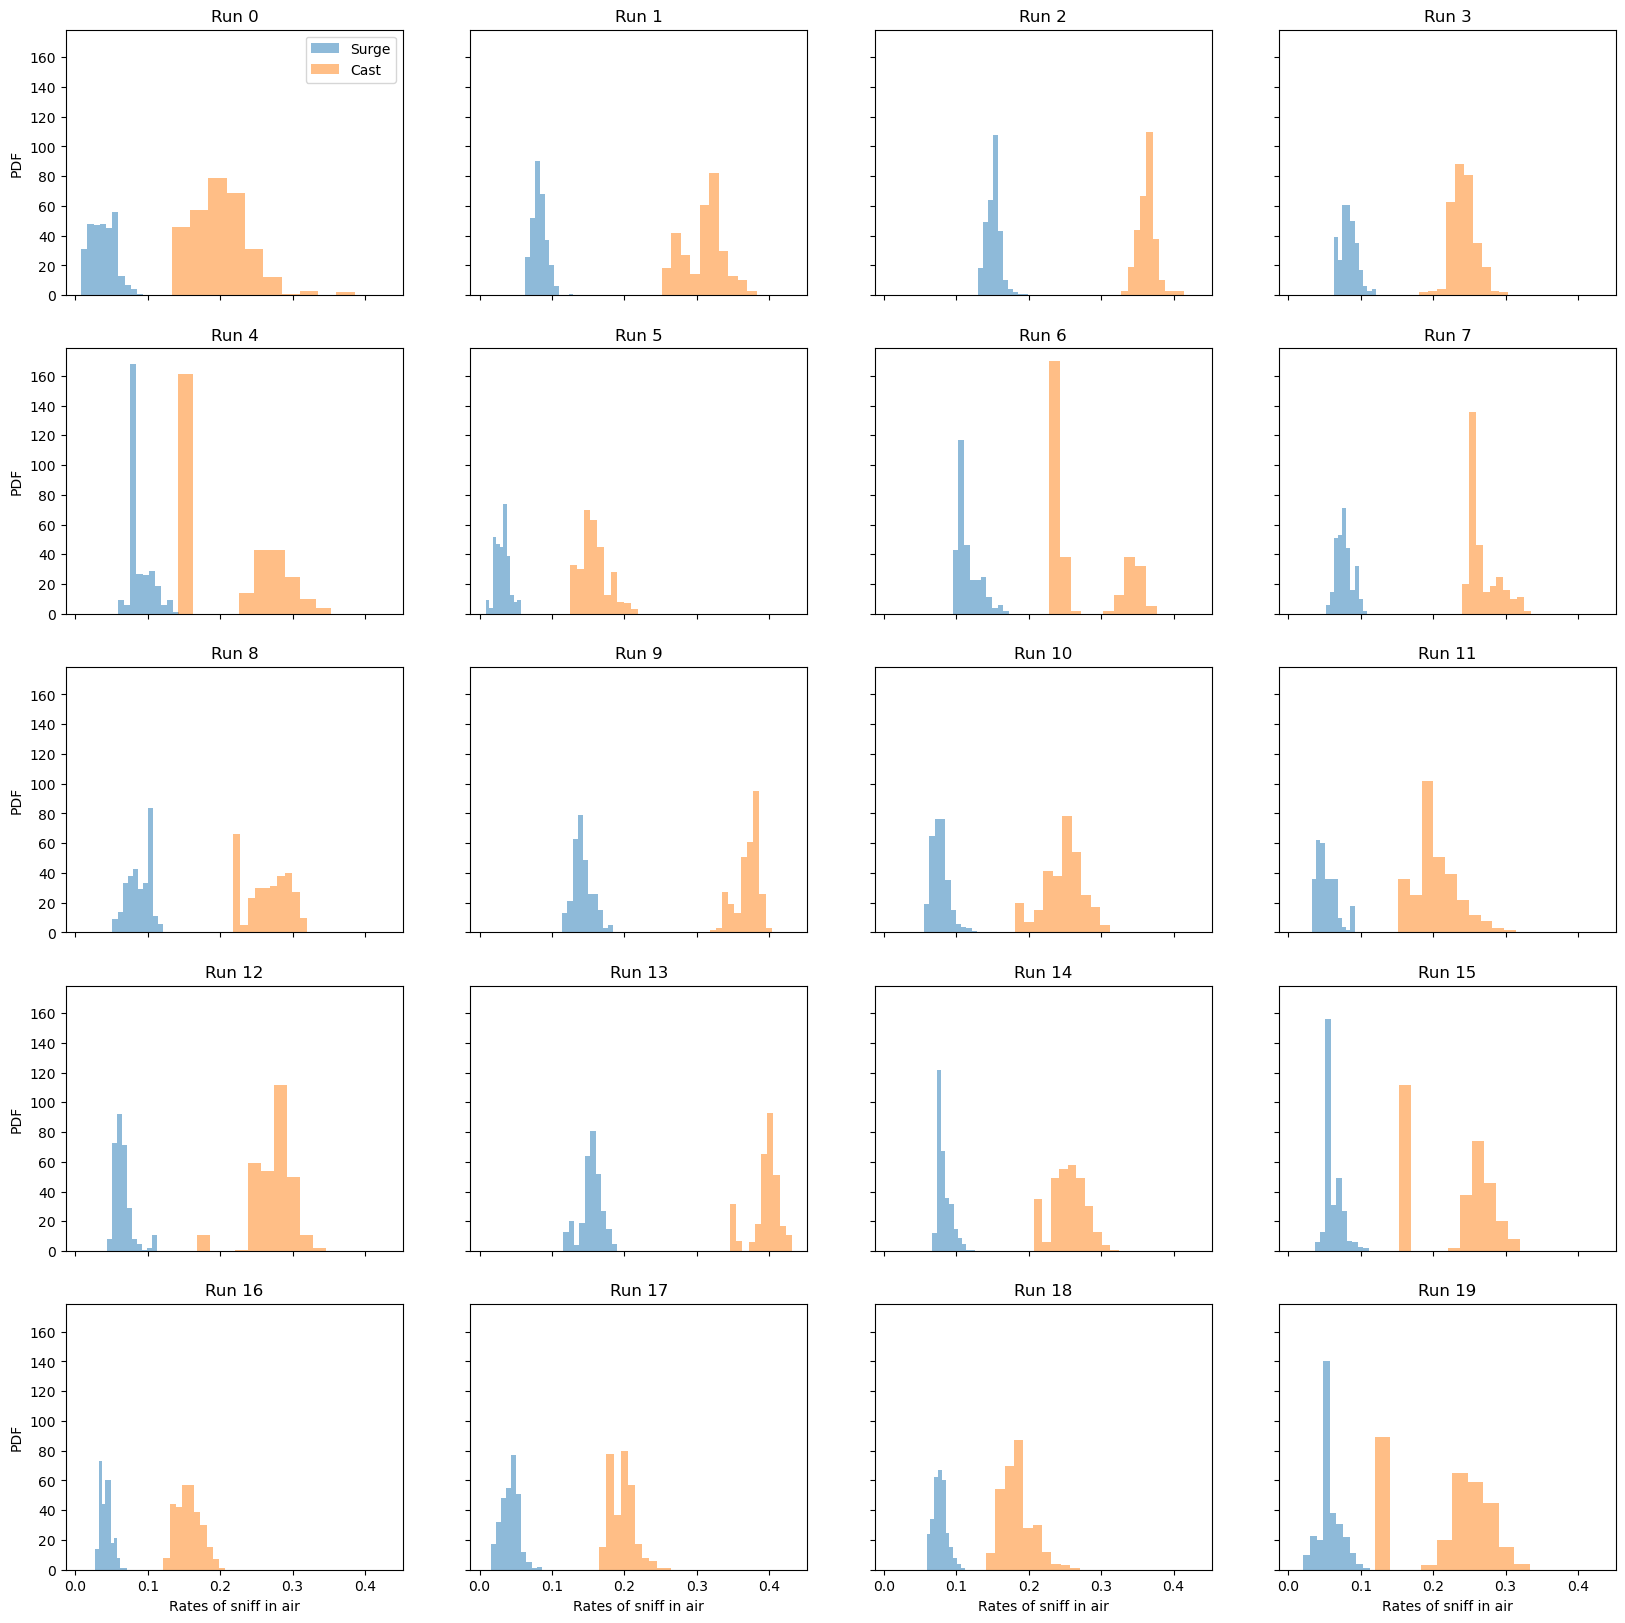

In [55]:
# Ground air
fig, axes = plt.subplots(5,4, figsize=(20,20), sharex=True, sharey=True)
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_c(ground_air_sims[i], ax=ax)
    ax.set_title(f'Run {i}')
    if i % 4 != 0:
        ax.set_ylabel(None)
    if i not in [16,17,18,19]:
        ax.set_xlabel(None)
    if i != 0:
        ax.legend().set_visible(False)

# Plot d

In [17]:
# Reconstructing beliefs
ground_air_sims_beliefs = []
for sim_list in ground_air_sims:
    b = Belief(model)
    sim_beliefs = [b]
    sim = sim_list[0]
    for i in range(len(sim)):
        b = b.update(sim.actions[i], sim.observations[i])
        sim_beliefs.append(b)
    ground_air_sims_beliefs.append(sim_beliefs)

In [18]:
vf_folder = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/'
vfs = [ValueFunction.load_from_file(vf_folder + f'run-{i}-VF.gzip', model) for i in range(20)]

In [19]:
from scipy.stats import entropy

In [20]:
ground_air_sims_bvals = []
for i in range(20):
    vf = vfs[i]
    b_list = ground_air_sims_beliefs[i]
    bvals = [np.max(np.dot(vf.alpha_vector_array, b.values)) for b in b_list]
    ground_air_sims_bvals.append(bvals)

In [21]:
len(ground_air_sims_bvals[0])

333

In [22]:
ground_air_sims_ents = []
for i in range(20):
    b_list = ground_air_sims_beliefs[i]
    ents = [entropy(b.values) for b in b_list]
    ground_air_sims_ents.append(ents)

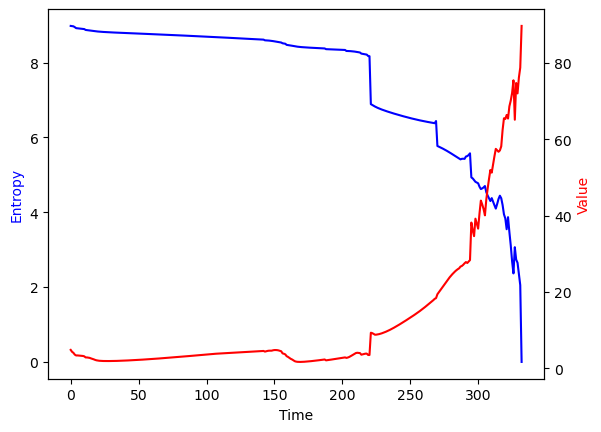

In [48]:
def plot_d(ents, b_vals, ax):
    ax.set_xlabel('Time')

    # Entropy
    ax.plot(np.arange(len(ents)), ents, color='blue')
    ax.set_ylabel('Entropy', color='blue')
    ax.tick_params(axis='y')

    ax2 = ax.twinx()

    # Value
    ax2.plot(np.arange(len(b_vals)), b_vals, color='red')
    ax2.set_ylabel('Value', color='red')
    ax2.tick_params(axis='y')

fig, ax1 = plt.subplots()
plot_d(ground_air_sims_ents[0], ground_air_sims_bvals[0], ax1)
plt.show()

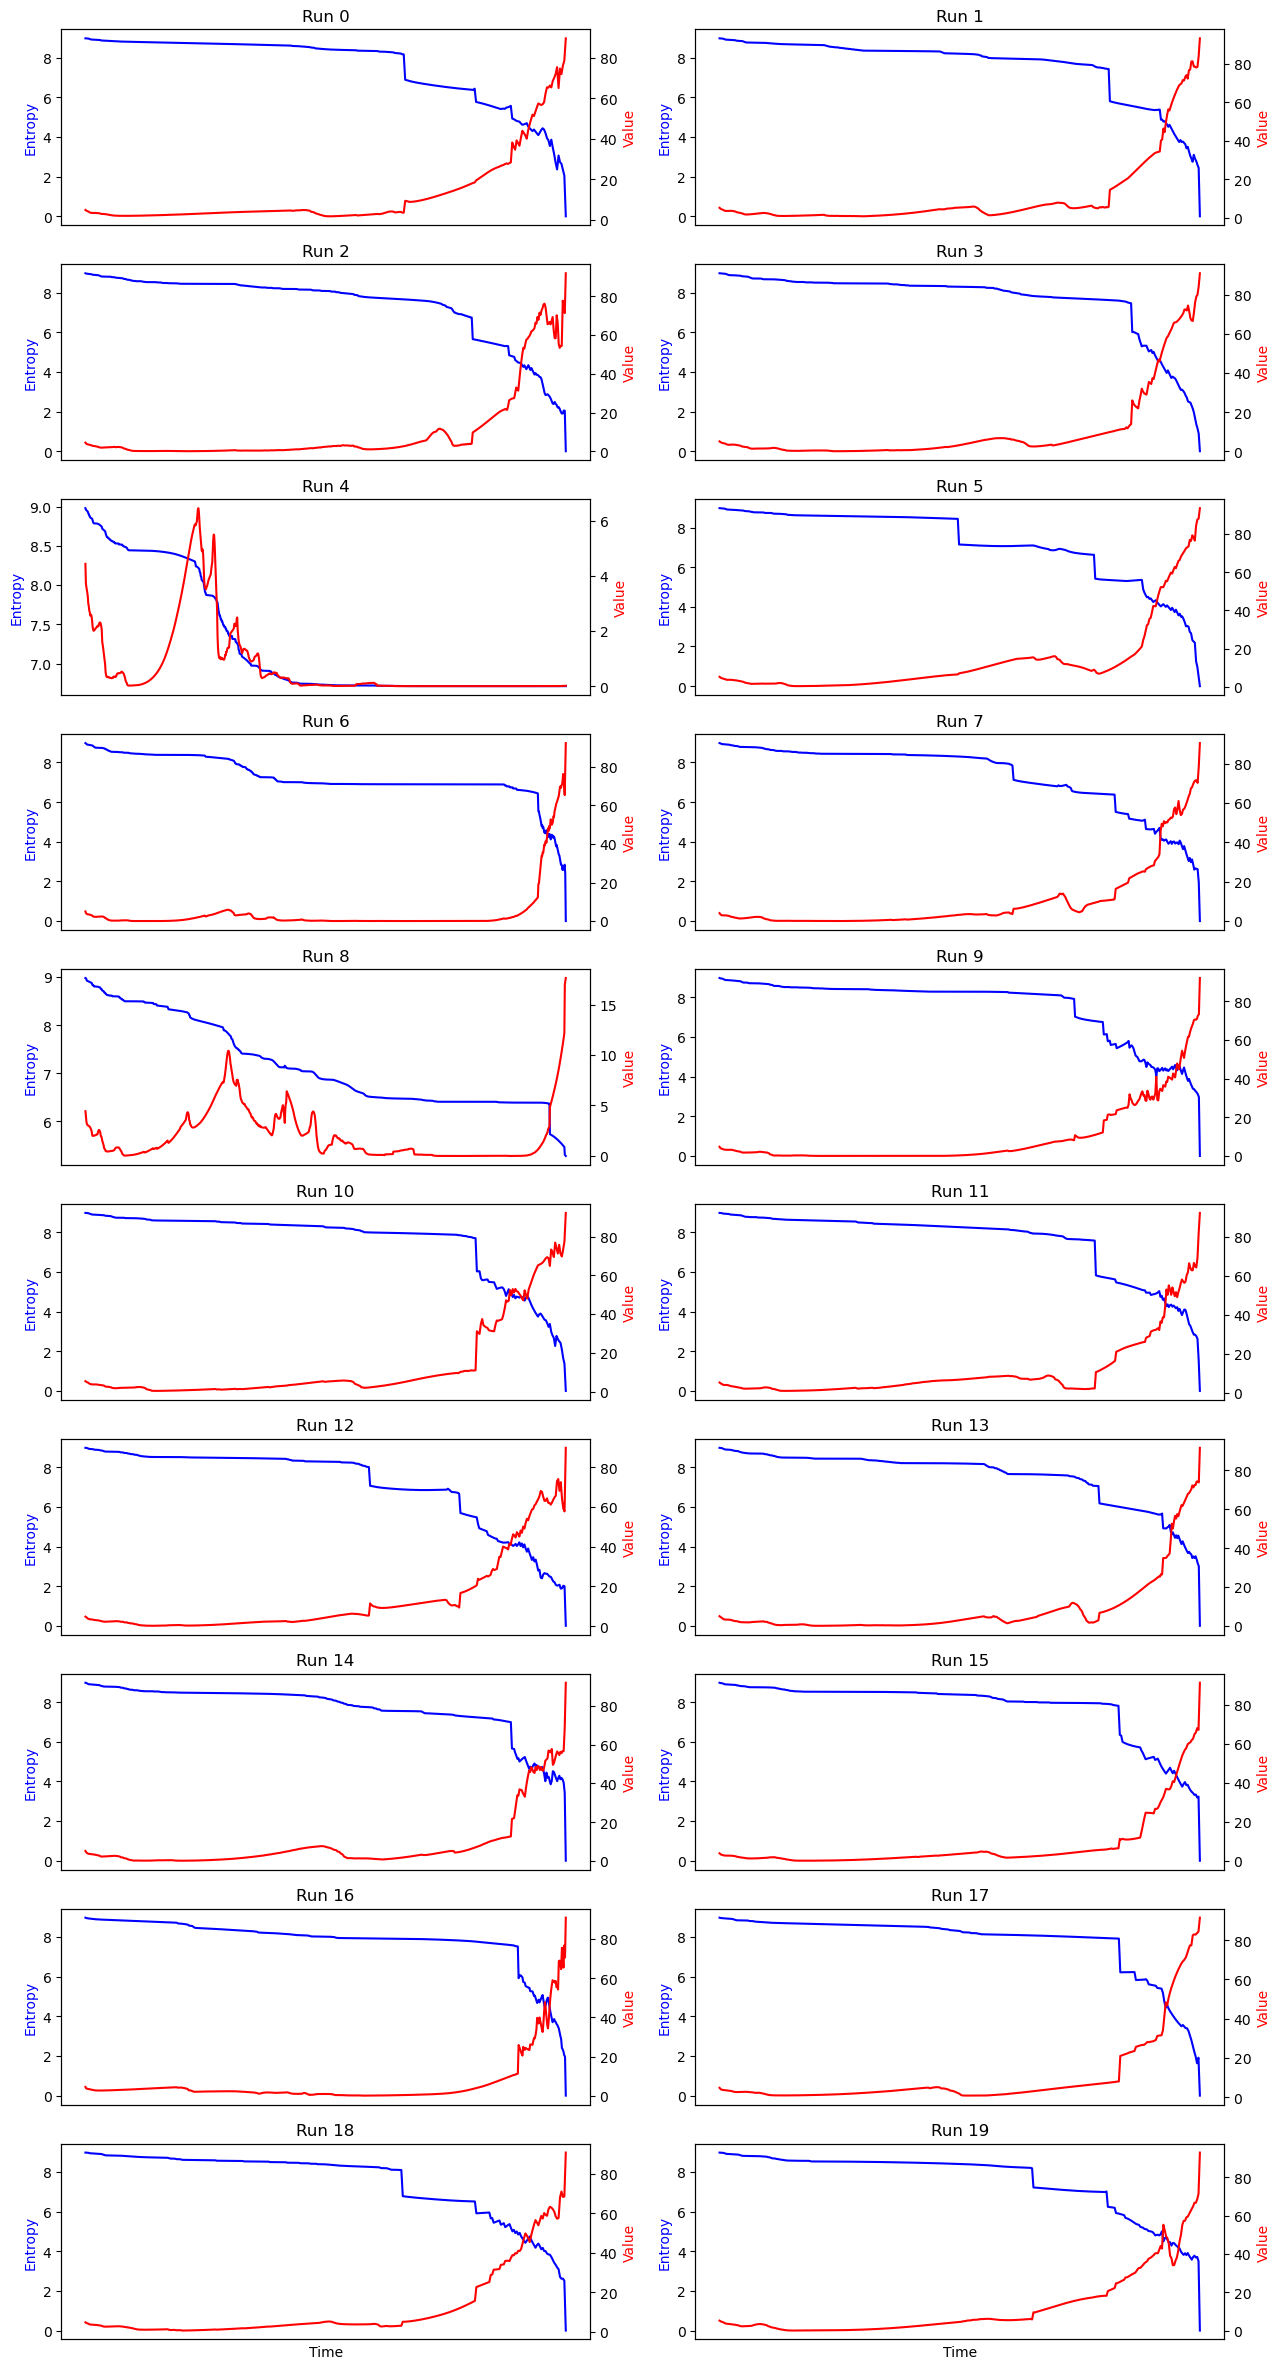

In [51]:
# Ground air
fig, axes = plt.subplots(10,2, figsize=(15,30), sharex=False, sharey=False)
ax_list = axes.ravel()
for i, ax in enumerate(ax_list):
    plot_d(ground_air_sims_ents[i], ground_air_sims_bvals[i], ax=ax)
    ax.set_title(f'Run {i}')

    ax.set_xticks([])
    if i not in [18,19]:
        ax.set_xlabel(None)